In [2]:
import pandas as pd
import numpy as np
import numpy_financial as npf
import quandl
import math
import random

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import copy

from scipy.optimize import fsolve
from sklearn.decomposition import PCA
import sklearn.covariance

# coundn't install pyportfolioopt

In [3]:
data = pd.read_excel('Project Input Data.xlsx', sheet_name='Security Price (Monthly)', header=2)

country = pd.read_excel('Project Input Data.xlsx', sheet_name='Security Information')
country['Country'].value_counts()
names = data.columns[1:]

UNITED STATES     10
CANADA            10
CHINA              9
JAPAN              5
UNITED KINGDOM     5
GERMANY            3
SWITZERLAND        3
FRANCE             2
FINLAND            1
DENMARK            1
NETHERLANDS        1
Name: Country, dtype: int64

##### Important assumptions:
#####  1. No risk free asset. Rf = 0. The portfolio is constructed entirely from the 50 risky securities universe.
#####  2. Using monthly percentage changes, not log(St/St-1)
#####  3. Assume monthly portfolio rebalancing with perfect securities liquidity.
##### Note: These simplifying assumptions limit the practicality and applicability of the models explored as they may not be realistic in practice. This exercise is for demonstration only.

In [6]:
ret = copy.deepcopy(data)

for i in names:
    ret[i] = ret[i].pct_change()

ret = ret[names][1:]+1

In [ ]:
# mean returns vector
mean = ret.mean()

# correlation and covariance matrix
ret.corr()
ret.cov()

## First, explore 1/N portfolio, i.e. portfolio equally weighted on all 50 stocks

In [438]:
m = []

for i in range(len(ret)):
    m.append(ret.iloc[i].mean())
    
N_mu = np.mean(m)
N_std = np.std(m)
N_Sharpe = (np.mean(m)-1)/np.std(m)
N = 100*np.cumprod(m)
N_Sharpe

0.3445588260852913

## Second, explore Markowitz mean-variance portfolios, first minimum risk portfolio, followed by market/tangent portfolio

### Min-risk portfolios, with cumulative window and rolling window, respectively


In [439]:
# starting with 24 months (2yrs), if less than 24 months of price data is used to estimate covariance matrix, the resulting portfolio show extremely wild fluctuations

l=np.repeat(1,50)
m=[]

for i in range(24,len(ret)):
    sigma=ret[0:i].cov()
    x=np.linalg.inv(sigma).dot(l)/np.transpose(l).dot(np.linalg.inv(sigma)).dot(l)
    m.append(ret.iloc[i].dot(x))
    
minrisk_mu=np.mean(m)
minrisk_std=np.std(m)
minrisk_Sharpe=(np.mean(m)-1)/np.std(m)
minrisk=100*np.cumprod(m)

In [441]:
d={'Security ID': country['Security ID'], 'weights': x}
d=pd.DataFrame(d)
dt = country.merge(d, 'left', 'Security ID')
check_limit(dt,countries,limit)

Exposure to  CANADA  exceeds  20.0 % !  Unfeasible.
Exposure to  JAPAN  exceeds  20.0 % !  Unfeasible.


In [442]:
minrisk_Sharpe

0.09285473125798745

In [444]:
# rolling 60 months (5yrs), if less than 60 months of price data is used to estimate covariance matrix, the resulting portfolio show extremely wild fluctuations

l=np.repeat(1,50)
m=[]

for i in range(60,len(ret)):
    sigma=ret[i-60:i].cov()
    x=np.linalg.inv(sigma).dot(l)/np.transpose(l).dot(np.linalg.inv(sigma)).dot(l)
    m.append(ret.iloc[i].dot(x))
    
minrisk_roll_mu=np.mean(m)
minrisk_roll_std=np.std(m)
minrisk_roll_Sharpe=(np.mean(m)-1)/np.std(m)
minrisk_roll=100*np.cumprod(m)

In [445]:
d={'Security ID': country['Security ID'], 'weights': x}
d=pd.DataFrame(d)
dt = country.merge(d, 'left', 'Security ID')
check_limit(dt,countries,limit)

Short exposure to  UNITED STATES  exceeds  20.0 % !  Unfeasible.
Exposure to  CANADA  exceeds  20.0 % !  Unfeasible.
Exposure to  JAPAN  exceeds  20.0 % !  Unfeasible.
Short exposure to  GERMANY  exceeds  20.0 % !  Unfeasible.
Exposure to  SWITZERLAND  exceeds  20.0 % !  Unfeasible.
Exposure to  FRANCE  exceeds  20.0 % !  Unfeasible.


In [446]:
minrisk_roll_Sharpe

0.07487314217573368

In [449]:
# use the entire time frame to build minrisk portfolio

l=np.repeat(1,50)
sigma=ret.cov()
x=np.linalg.inv(sigma).dot(l)/np.transpose(l).dot(np.linalg.inv(sigma)).dot(l)

In [450]:
d={'Security ID': country['Security ID'], 'weights': x}
d=pd.DataFrame(d)
dt = country.merge(d, 'left', 'Security ID')
check_limit(dt,countries,limit)

Exposure to  CANADA  exceeds  20.0 % !  Unfeasible.
Exposure to  JAPAN  exceeds  20.0 % !  Unfeasible.


In [451]:
(np.transpose(x).dot(ret.mean())-1)/np.sqrt(np.transpose(x).dot(ret.cov()).dot(x))

0.40646290528486223

### Market/tangent portfolios, with cumulative window and rolling window, respectively

In [452]:
# to be be consistent with minrisk portfolios for comparison, also use cumulative window starting with 24 months

l=np.repeat(1,50)
m=[]

for i in range(24,len(ret)):
    mu=ret[0:i].mean()
    sigma=ret[0:i].cov()
    tao_m=1/np.transpose(l).dot(np.linalg.inv(sigma)).dot(mu-1)
    x_m=tao_m*np.linalg.inv(sigma).dot(mu-1)
    m.append(ret.iloc[i].dot(x_m))
    
market_mu = np.mean(m)
market_std = np.std(m)
market_Sharpe = (np.mean(m)-1)/np.std(m)
market = 100*np.cumprod(m)

In [454]:
d={'Security ID': country['Security ID'], 'weights': x_m}
d=pd.DataFrame(d)
dt = country.merge(d, 'left', 'Security ID')
check_limit(dt,countries,limit)

Exposure to  UNITED STATES  exceeds  20.0 % !  Unfeasible.
Exposure to  CANADA  exceeds  20.0 % !  Unfeasible.
Short exposure to  UNITED KINGDOM  exceeds  20.0 % !  Unfeasible.
Exposure to  FRANCE  exceeds  20.0 % !  Unfeasible.


In [455]:
market_Sharpe

0.13127155262958526

In [457]:
# use rolling window with 30 months

l=np.repeat(1,50)
m=[]

for i in range(30,len(ret)):
    mu=ret[i-30:i].mean()
    sigma=ret[i-30:i].cov()
    tao_m=1/np.transpose(l).dot(np.linalg.inv(sigma)).dot(mu-1)
    x_m=tao_m*np.linalg.inv(sigma).dot(mu-1)
    m.append(ret.iloc[i].dot(x_m))
    
market_roll_mu = np.mean(m)
market_roll_std = np.std(m)
market_roll_Sharpe = (np.mean(m)-1)/np.std(m)
market_roll = 100*np.cumprod(m)

In [458]:
d={'Security ID': country['Security ID'], 'weights': x_m}
d=pd.DataFrame(d)
dt = country.merge(d, 'left', 'Security ID')
check_limit(dt,countries,limit)

Exposure to  UNITED STATES  exceeds  20.0 % !  Unfeasible.
Exposure to  CANADA  exceeds  20.0 % !  Unfeasible.
Exposure to  CHINA  exceeds  20.0 % !  Unfeasible.
Exposure to  UNITED KINGDOM  exceeds  20.0 % !  Unfeasible.
Short exposure to  GERMANY  exceeds  20.0 % !  Unfeasible.
Exposure to  SWITZERLAND  exceeds  20.0 % !  Unfeasible.
Short exposure to  FRANCE  exceeds  20.0 % !  Unfeasible.
Exposure to  NETHERLANDS  exceeds  20.0 % !  Unfeasible.


In [459]:
market_roll_Sharpe

0.11774371655979271

In [460]:
# use the entire time frame to build market portfolio

l=np.repeat(1,50)
mu=ret.mean()
sigma=ret.cov()
tao_m=1/np.transpose(l).dot(np.linalg.inv(sigma)).dot(mu-1)
x_m=tao_m*np.linalg.inv(sigma).dot(mu-1)


In [461]:
d={'Security ID': country['Security ID'], 'weights': x_m}
d=pd.DataFrame(d)
dt = country.merge(d, 'left', 'Security ID')
check_limit(dt,countries,limit)

Exposure to  UNITED STATES  exceeds  20.0 % !  Unfeasible.
Exposure to  CANADA  exceeds  20.0 % !  Unfeasible.
Short exposure to  UNITED KINGDOM  exceeds  20.0 % !  Unfeasible.
Exposure to  FRANCE  exceeds  20.0 % !  Unfeasible.


In [462]:
(np.transpose(x_m).dot(ret.mean())-1)/np.sqrt(np.transpose(x_m).dot(ret.cov()).dot(x_m))

0.8198405036148345

# PCA portfolios

In [463]:
# PC1 portfolio with cumulative window starting with 24 months

PC1=[]

for i in range(24,len(ret)):
    pc1=PCA(n_components=5).fit(ret[0:i].cov()).components_[0]
    weights=pc1/sum(pc1) # rescale weights
    PC1.append(ret.iloc[i].dot(weights))

pca_mu=np.mean(PC1)
pca_std=np.std(PC1)
pca_Sharpe=(np.mean(PC1)-1)/np.std(PC1)
pca=100*np.cumprod(PC1)

# PCA(n_components=5).fit(ret.cov()).explained_variance_ratio_

In [464]:
d={'Security ID': country['Security ID'], 'weights': weights}
d=pd.DataFrame(d)
dt = country.merge(d, 'left', 'Security ID')
check_limit(dt,countries,limit)

Short exposure to  CANADA  exceeds  20.0 % !  Unfeasible.
Exposure to  CHINA  exceeds  20.0 % !  Unfeasible.
Short exposure to  UNITED KINGDOM  exceeds  20.0 % !  Unfeasible.


In [465]:
pca_Sharpe

0.14309960151696116

In [466]:
# PC1 portfolio with rolling window starting with 80 months

PC1=[]

for i in range(80,len(ret)):
    pc1=PCA(n_components=5).fit(ret[i-80:i].cov()).components_[0]
    weights=pc1/sum(pc1) # rescale weights
    PC1.append(ret.iloc[i].dot(weights))

pca_roll_mu=np.mean(PC1)
pca_roll_std=np.std(PC1)
pca_roll_Sharpe=(np.mean(PC1)-1)/np.std(PC1)
pca_roll=100*np.cumprod(PC1)


In [467]:
d={'Security ID': country['Security ID'], 'weights': weights}
d=pd.DataFrame(d)
dt = country.merge(d, 'left', 'Security ID')
check_limit(dt,countries,limit)

Exposure to  CANADA  exceeds  20.0 % !  Unfeasible.
Exposure to  CHINA  exceeds  20.0 % !  Unfeasible.


In [468]:
pca_roll_Sharpe

0.14754771144727716

In [471]:
# use the entire time frame to build PCA portfolio

pc1=PCA(n_components=5).fit(ret.cov()).components_[0]
weights=pc1/sum(pc1) # rescale weights

# PCA(n_components=5).fit(ret.cov()).explained_variance_ratio_

In [472]:
d={'Security ID': country['Security ID'], 'weights': weights}
d=pd.DataFrame(d)
dt = country.merge(d, 'left', 'Security ID')
check_limit(dt,countries,limit)

Short exposure to  CANADA  exceeds  20.0 % !  Unfeasible.
Exposure to  CHINA  exceeds  20.0 % !  Unfeasible.
Short exposure to  UNITED KINGDOM  exceeds  20.0 % !  Unfeasible.


In [473]:
(np.transpose(weights).dot(ret.mean())-1)/np.sqrt(np.transpose(weights).dot(ret.cov()).dot(weights))

0.18767834954230114

## Generate portfolios with randomly sampled weights, plot in the (volatility, return) space to explore min-risk and optimal risk portfolios

#### Note: np.random.random() only generates positive (0,1) weights and does not allow short exposure

In [487]:
mu=[]
std=[]
p_weights=[]
Sharpe=[]

for i in range(10000):
    weight = np.random.random(50)
    weights = weight/sum(weight)
    p_weights.append(weights)
    mu.append(np.transpose(weights).dot(ret.mean()))
    std.append(np.sqrt(np.transpose(weights).dot(ret.cov()).dot(weights)))
    # Sharpe ratio for each portfolio, assume rf=0
    Sharpe.append((np.transpose(weights).dot(ret.mean())-1)/np.sqrt(np.transpose(weights).dot(ret.cov()).dot(weights)))
    # plt.scatter(std[i],mu[i])

In [488]:
data={'Returns': mu, 'Volatility': std}

for i in range(len(p_weights)):
    data[ 'Sharpe ratio' ] = [ i for i in Sharpe ]   
    
for counter, symbol in enumerate(ret.columns.tolist()):
    data[ symbol ] = [ w[counter] for w in p_weights ]

portfolios = pd.DataFrame(data)
portfolios.head()

,Returns,Volatility,Sharpe ratio,CM-CA,BMO-CA,TD-CA,BNS-CA,NA-CA,BCE-CA,EMP.A-CA,...,AAPL-US,JPM-US,PG-US,INTC-US,VZ-US,DIS-US,MSFT-US,AMZN-US,UPS-US,GOOGL-US
0,1.012180,0.034391,0.354167,0.035739,0.009729,0.017361,0.001920,0.014997,0.024954,0.007140,...,0.015844,0.014421,0.013708,0.015364,0.006625,0.003435,0.020138,0.025642,0.003296,0.035579
1,1.011163,0.032725,0.341121,0.001224,0.013648,0.022535,0.021262,0.006013,0.002389,0.014590,...,0.029348,0.001761,0.031815,0.023443,0.028181,0.019890,0.031087,0.035353,0.020892,0.022462
2,1.011100,0.033025,0.336103,0.030556,0.020089,0.029161,0.030415,0.017648,0.015980,0.015675,...,0.007843,0.026262,0.024993,0.022048,0.002686,0.038140,0.026940,0.036653,0.021429,0.020893
3,1.011527,0.033372,0.345420,0.008122,0.016757,0.009593,0.028884,0.022074,0.019739,0.009052,...,0.019782,0.032018,0.035412,0.033693,0.012256,0.036479,0.023428,0.009729,0.003791,0.011825
4,1.010983,0.034118,0.321919,0.009020,0.021054,0.010551,0.015471,0.022086,0.035916,0.025617,...,0.012125,0.011432,0.031028,0.004781,0.010585,0.000481,0.036388,0.030084,0.023404,0.005715


Text(0.0330748049135817, 1.0113962159540237, '1/N')

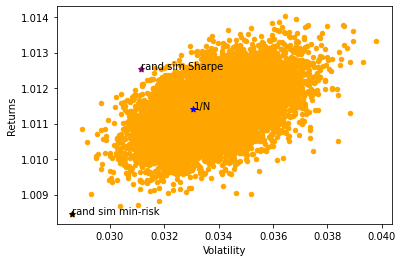

In [492]:
min_risk = portfolios.iloc[portfolios['Volatility'].idxmin()]
opt_Sharpe = portfolios.iloc[portfolios['Sharpe ratio'].idxmax()]

portfolios.plot.scatter(x='Volatility', y='Returns',color='orange')
plt.scatter(min_risk[1], min_risk[0],color='black',marker='*')
plt.scatter(opt_Sharpe[1], opt_Sharpe[0],color='purple',marker='*')
plt.scatter(N_std,N_mu,color='blue',marker='*')
plt.text(min_risk[1], min_risk[0], 'rand sim min-risk')
plt.text(opt_Sharpe[1], opt_Sharpe[0], 'rand sim Sharpe')
plt.text(N_std,N_mu, '1/N')

In [292]:
countries=['UNITED STATES','CANADA','CHINA','JAPAN','UNITED KINGDOM','GERMANY','SWITZERLAND','FRANCE','FINLAND','DENMARK','NETHERLANDS']
limit=0.2

In [153]:
# define the function to check no country exposure exceeds 20%

def check_limit(table, countries, limit):
    for i in countries:
        if table.loc[table['Country'] == i, 'weights'].sum() < -limit :
            print('Short exposure to ', i, ' exceeds ', 100*limit, '% !  Unfeasible.')
        elif table.loc[table['Country'] == i, 'weights'].sum() <= limit :
            continue            
        else: 
            print('Exposure to ', i, ' exceeds ', 100*limit, '% !  Unfeasible.')
            

In [479]:
d={'Security ID': min_risk.index[3:], 'weights': min_risk[3:]}
d=pd.DataFrame(d)
dt = country.merge(d, 'left', 'Security ID')
check_limit(dt,countries,limit)

Exposure to  CANADA  exceeds  20.0 % !  Unfeasible.


In [480]:
min_risk[:3]

Returns         1.010229
Volatility      0.028933
Sharpe ratio    0.353527
Name: 7032, dtype: float64

In [481]:
d={'Security ID': opt_Sharpe.index[3:], 'weights': opt_Sharpe[3:]}
d=pd.DataFrame(d)
dt = country.merge(d, 'left', 'Security ID')
check_limit(dt,countries,limit)

Exposure to  UNITED STATES  exceeds  20.0 % !  Unfeasible.


In [482]:
opt_Sharpe[:3]

Returns         1.012590
Volatility      0.030860
Sharpe ratio    0.407982
Name: 5510, dtype: float64

In [483]:
# explore the second best optimal portfolio in terms of Sharpe ratio

second_opt_Sharpe = portfolios.iloc[portfolios['Sharpe ratio'].sort_values().index[-2]]
d={'Security ID': second_opt_Sharpe.index[3:], 'weights': second_opt_Sharpe[3:]}
d=pd.DataFrame(d)
dt = country.merge(d, 'left', 'Security ID')
check_limit(dt,countries,limit)

Exposure to  UNITED STATES  exceeds  20.0 % !  Unfeasible.


### Now we need to filter out the randomly sampled weights vectors that violate the 20% exposure limit constraint

In [393]:
# define the function to check the weights vector that no country exposure exceeds 20%
def check_weights(table, countries, limit):
    for i in countries:
        if table.loc[table['Country'] == i, 'weights'].sum() < -limit :
            return False
            break
        elif table.loc[table['Country'] == i, 'weights'].sum() <= limit :
            continue            
        else: 
            return False
            break
            

#### Use a uniform random weights sampling from (-0.02, 0.02) range. This allows both long and short exposures.

In [496]:
mu=[]
std=[]
p_weights=[]
Sharpe=[]

for i in range(10000):
    weight = np.random.uniform(-0.02,0.02,50)
    weights = weight/sum(weight)
    d={'Security ID': country['Security ID'], 'weights': weights}
    d=pd.DataFrame(d)
    dt = country.merge(d, 'left', 'Security ID')
    if check_weights(dt, countries, limit) == False:
        continue
    p_weights.append(weights)
    mu.append(np.transpose(weights).dot(ret.mean()))
    std.append(np.sqrt(np.transpose(weights).dot(ret.cov()).dot(weights)))
    # Sharpe ratio for each portfolio, assume rf=0
    Sharpe.append((np.transpose(weights).dot(ret.mean())-1)/np.sqrt(np.transpose(weights).dot(ret.cov()).dot(weights)))
    # plt.scatter(std[i],mu[i])

In [497]:
data={'Returns': mu, 'Volatility': std}

for i in range(len(p_weights)):
    data[ 'Sharpe ratio' ] = [ i for i in Sharpe ]   
    
for counter, symbol in enumerate(ret.columns.tolist()):
    data[ symbol ] = [ w[counter] for w in p_weights ]

portfolios = pd.DataFrame(data)
portfolios.head()

,Returns,Volatility,Sharpe ratio,CM-CA,BMO-CA,TD-CA,BNS-CA,NA-CA,BCE-CA,EMP.A-CA,...,AAPL-US,JPM-US,PG-US,INTC-US,VZ-US,DIS-US,MSFT-US,AMZN-US,UPS-US,GOOGL-US
0,1.016769,0.067731,0.247577,0.136046,0.041024,0.051399,-0.105082,-0.026946,-0.065274,0.129416,...,0.004310,-0.139241,-0.132273,0.034253,-0.190589,0.171120,0.203405,0.172913,-0.149566,0.205728
1,1.007940,0.049280,0.161122,0.017648,0.029706,0.173703,0.016766,-0.039581,0.062916,-0.167425,...,0.157235,-0.086705,0.136820,0.063816,0.106448,-0.080323,-0.116618,0.019373,0.043397,-0.081033
2,1.010056,0.042729,0.235341,0.092519,0.018715,-0.002575,-0.075249,0.092234,-0.007191,-0.063080,...,-0.047083,-0.051103,0.082613,0.052696,0.082448,-0.003452,-0.077261,-0.066216,-0.021886,0.092490
3,1.010699,0.040732,0.262672,0.070773,0.061100,-0.044520,0.073933,-0.044626,-0.082480,0.080225,...,0.041375,0.066599,0.062061,-0.079154,-0.027792,0.041392,-0.085788,-0.045468,0.076416,0.082280
4,1.010008,0.051053,0.196024,0.126429,-0.030772,-0.114879,0.025793,0.047851,-0.062014,0.092619,...,-0.000165,-0.082934,-0.138971,-0.006287,-0.004319,0.067139,0.121353,0.049532,-0.072084,0.079340


Text(0.0330748049135817, 1.0113962159540237, '1/N')

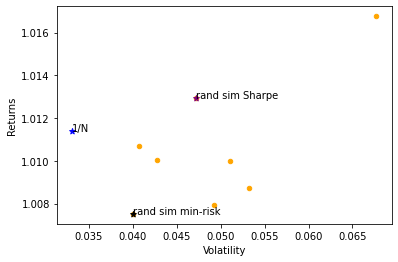

In [498]:
min_risk = portfolios.iloc[portfolios['Volatility'].idxmin()]
opt_Sharpe = portfolios.iloc[portfolios['Sharpe ratio'].idxmax()]

portfolios.plot.scatter(x='Volatility', y='Returns',color='orange')
plt.scatter(min_risk[1], min_risk[0],color='black',marker='*')
plt.scatter(opt_Sharpe[1], opt_Sharpe[0],color='purple',marker='*')
plt.scatter(N_std,N_mu,color='blue',marker='*')
plt.text(min_risk[1], min_risk[0], 'rand sim min-risk')
plt.text(opt_Sharpe[1], opt_Sharpe[0], 'rand sim Sharpe')
plt.text(N_std,N_mu, '1/N')

#### Note that due to the (-0.2, 0.2) sampling range, the allowable portfolios under the constraint are too sparse. 

In [499]:
min_risk[:3]

Returns         1.007514
Volatility      0.040006
Sharpe ratio    0.187822
Name: 6, dtype: float64

In [500]:
opt_Sharpe[:3]

Returns         1.012951
Volatility      0.047180
Sharpe ratio    0.274509
Name: 5, dtype: float64

#### Try a new sampling range (-0.01, 0.05), focus on long exposures, limit short exposures

In [501]:
mu=[]
std=[]
p_weights=[]
Sharpe=[]

for i in range(10000):
    weight = np.random.uniform(-0.01,0.05,50)
    weights = weight/sum(weight)
    d={'Security ID': country['Security ID'], 'weights': weights}
    d=pd.DataFrame(d)
    dt = country.merge(d, 'left', 'Security ID')
    if check_weights(dt, countries, limit) == False:
        continue
    p_weights.append(weights)
    mu.append(np.transpose(weights).dot(ret.mean()))
    std.append(np.sqrt(np.transpose(weights).dot(ret.cov()).dot(weights)))
    # Sharpe ratio for each portfolio, assume rf=0
    Sharpe.append((np.transpose(weights).dot(ret.mean())-1)/np.sqrt(np.transpose(weights).dot(ret.cov()).dot(weights)))
    # plt.scatter(std[i],mu[i])

In [502]:
data={'Returns': mu, 'Volatility': std}

for i in range(len(p_weights)):
    data[ 'Sharpe ratio' ] = [ i for i in Sharpe ]   
    
for counter, symbol in enumerate(ret.columns.tolist()):
    data[ symbol ] = [ w[counter] for w in p_weights ]

portfolios = pd.DataFrame(data)
portfolios.head()

,Returns,Volatility,Sharpe ratio,CM-CA,BMO-CA,TD-CA,BNS-CA,NA-CA,BCE-CA,EMP.A-CA,...,AAPL-US,JPM-US,PG-US,INTC-US,VZ-US,DIS-US,MSFT-US,AMZN-US,UPS-US,GOOGL-US
0,1.010185,0.037281,0.273207,0.036175,-0.004195,0.035235,0.008104,0.040287,-0.004229,0.007049,...,0.020914,0.018647,0.004701,0.000540,0.011934,-0.008040,0.029251,0.004281,0.053400,0.010192
1,1.011923,0.036626,0.325521,-0.008289,0.038589,-0.001641,0.041162,0.026892,-0.005914,0.024235,...,0.031494,0.031474,0.024095,0.003100,-0.002222,0.041985,0.035568,0.004936,-0.010279,-0.009821
2,1.012376,0.033295,0.371702,-0.002304,0.033280,0.038418,0.008365,0.016345,0.021622,0.036332,...,0.039190,0.006856,0.005944,0.009870,-0.007969,0.042969,0.003694,0.037926,0.004838,0.022318
3,1.010884,0.033586,0.324061,0.015697,0.008979,-0.010579,0.024666,0.027941,0.011915,0.013557,...,-0.009525,-0.004659,0.001468,0.003067,0.047022,0.040580,-0.001557,0.012982,0.050277,-0.005445
4,1.009872,0.034523,0.285941,0.034071,0.037436,0.005900,0.013011,0.015515,0.013185,-0.008571,...,0.020786,0.019232,0.046634,0.014943,0.004265,-0.004237,0.046979,-0.009817,0.046064,0.011247


Text(0.0330748049135817, 1.0113962159540237, '1/N')

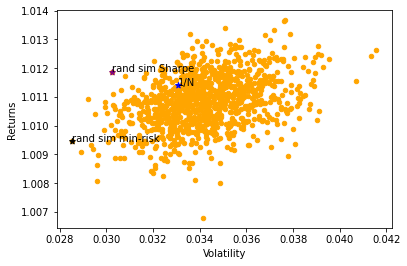

In [504]:
min_risk = portfolios.iloc[portfolios['Volatility'].idxmin()]
opt_Sharpe = portfolios.iloc[portfolios['Sharpe ratio'].idxmax()]

portfolios.plot.scatter(x='Volatility', y='Returns',color='orange')
plt.scatter(min_risk[1], min_risk[0],color='black',marker='*')
plt.scatter(opt_Sharpe[1], opt_Sharpe[0],color='purple',marker='*')
plt.scatter(N_std,N_mu,color='blue',marker='*')
plt.text(min_risk[1], min_risk[0], 'rand sim min-risk')
plt.text(opt_Sharpe[1], opt_Sharpe[0], 'rand sim Sharpe')
plt.text(N_std,N_mu, '1/N')

In [506]:
min_risk[:3]

Returns         1.009448
Volatility      0.028529
Sharpe ratio    0.331183
Name: 308, dtype: float64

In [507]:
opt_Sharpe[:3]

Returns         1.011873
Volatility      0.030246
Sharpe ratio    0.392532
Name: 268, dtype: float64

### Now come back to using the (0,1) range, with the filter on

In [508]:
mu=[]
std=[]
p_weights=[]
Sharpe=[]

for i in range(10000):
    weight = np.random.uniform(0,1,50)
    weights = weight/sum(weight)
    d={'Security ID': country['Security ID'], 'weights': weights}
    d=pd.DataFrame(d)
    dt = country.merge(d, 'left', 'Security ID')
    if check_weights(dt, countries, limit) == False:
        continue
    p_weights.append(weights)
    mu.append(np.transpose(weights).dot(ret.mean()))
    std.append(np.sqrt(np.transpose(weights).dot(ret.cov()).dot(weights)))
    # Sharpe ratio for each portfolio, assume rf=0
    Sharpe.append((np.transpose(weights).dot(ret.mean())-1)/np.sqrt(np.transpose(weights).dot(ret.cov()).dot(weights)))
    # plt.scatter(std[i],mu[i])

In [509]:
data={'Returns': mu, 'Volatility': std}

for i in range(len(p_weights)):
    data[ 'Sharpe ratio' ] = [ i for i in Sharpe ]   
    
for counter, symbol in enumerate(ret.columns.tolist()):
    data[ symbol ] = [ w[counter] for w in p_weights ]

portfolios = pd.DataFrame(data)
portfolios.head()

,Returns,Volatility,Sharpe ratio,CM-CA,BMO-CA,TD-CA,BNS-CA,NA-CA,BCE-CA,EMP.A-CA,...,AAPL-US,JPM-US,PG-US,INTC-US,VZ-US,DIS-US,MSFT-US,AMZN-US,UPS-US,GOOGL-US
0,1.011353,0.032435,0.350041,0.037677,0.029606,0.006333,0.008795,0.014409,0.016933,0.011672,...,0.030770,0.004813,0.015505,0.022893,0.008158,0.019241,0.025513,0.008728,0.027971,0.028390
1,1.011426,0.035916,0.318138,0.001891,0.002216,0.032157,0.024298,0.034650,0.036982,0.000019,...,0.010092,0.018615,0.019171,0.040855,0.006914,0.003883,0.009809,0.008967,0.019131,0.015903
2,1.011069,0.032509,0.340484,0.024393,0.003596,0.024514,0.012552,0.013328,0.023929,0.022065,...,0.000210,0.021991,0.011739,0.022462,0.031342,0.019713,0.005474,0.018769,0.037145,0.011607
3,1.010544,0.032889,0.320597,0.029140,0.028510,0.028923,0.007795,0.015200,0.005557,0.019027,...,0.022974,0.009295,0.039626,0.017663,0.005061,0.022061,0.010019,0.014089,0.001671,0.026104
4,1.011730,0.035398,0.331373,0.022752,0.029483,0.015471,0.005488,0.006148,0.012860,0.028749,...,0.024302,0.010668,0.010582,0.002054,0.016387,0.024185,0.022642,0.029894,0.005908,0.024987


Text(0.0330748049135817, 1.0113962159540237, '1/N')

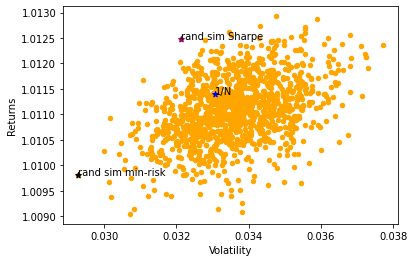

In [510]:
min_risk = portfolios.iloc[portfolios['Volatility'].idxmin()]
opt_Sharpe = portfolios.iloc[portfolios['Sharpe ratio'].idxmax()]

portfolios.plot.scatter(x='Volatility', y='Returns',color='orange')
plt.scatter(min_risk[1], min_risk[0],color='black',marker='*')
plt.scatter(opt_Sharpe[1], opt_Sharpe[0],color='purple',marker='*')
plt.scatter(N_std,N_mu,color='blue',marker='*')
plt.text(min_risk[1], min_risk[0], 'rand sim min-risk')
plt.text(opt_Sharpe[1], opt_Sharpe[0], 'rand sim Sharpe')
plt.text(N_std,N_mu, '1/N')

In [512]:
min_risk[:3]

Returns         1.009805
Volatility      0.029287
Sharpe ratio    0.334781
Name: 297, dtype: float64

In [513]:
opt_Sharpe[:3]

Returns         1.012483
Volatility      0.032115
Sharpe ratio    0.388694
Name: 201, dtype: float64

# Summary
### 1. All discussion of mean returns, volatility and Sharpe ratio are on a monthly basis. Assume monthly rebalancing. Assume no risk free asset available. Rf=0. Entire portfolio is selected from the 50 stocks universe.
### 2. Portfolio optimization mainly uses three set-up: minimize risk given return, maximize return given risk, or find the optimal portfolio that gives most excess return per unit of risk (e.g. Sharpe ratio)
### 3. I used four methods to explore optimal portfolios: random simulation, minimum risk portfolio, market/tangent portfolio, PCA portfolio. For most of these methods (except PCA), portfolio construction relies on estimating mean return vector and covariance matrix using historical data. Most of these methods use formulations based on theoretical set-up with simplifying assumptions, which may not be applicable in real scenarios. 
### 4. I used two approaches to using historical data: the cumulative approach (starting from the earliest available data), or the rolling window approach. Alternatively, there is also a third approach to assign more weights to more recent data, and less weights to more distant past data. Specific methods include semicovariance, exponential covariance, covariance shrinkage etc. These algorithms are included in the pyportfolioopt package and beyond the scope of my knowledge.
### 5. My results show large fluctuations when different rolling time windows are used. The selection of rolling time frames is quite arbitrary and tend to give unstable results. This underscores the perils and vulnerability of relying on historical data to estimate the mean and covariance matrix. Estimation itself is extremely difficult and also key to any optimization. Exact estimation is nearly impossible as the true mean and covariance matrix itself evolves over time. This echoes with the adage that we cannot overly rely on historical data to predict future performance.
### 6. I measured the risk-return tradeoff only using Sharpe ratio. Other metrics can be used, including Treynor Ratio and Jensen's alpha. Treynor ratio is the excess return divided by the portfolio beta, which is not easy to estimate. For Jensen's alpha, the portfolio is compared against a benchmark, usually a market index. Due to limited information given, this is not applicable in this problem.
### 7. All methods I explored in the beginning give portfolios that violate the exposure constraint. Therefore I decided to use random sampling to filter out the portfolios that satisfy this constraint.


# Recommendations and alternative approaches
### 1. I only explored returns as percentage changes. Log returns can be similarly explored for portfolio optimization.
### 2. The pyportfolioopt package has many cool and advanced optimization techniques. It is definitely worthwhile to explore its functionalities in portfolio optimization.